In [ ]:
# imported packages
!pip install -q researchpy
import researchpy as repy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
import gdown

In [ ]:
# imported csv (1)
!gdown --id 1rpQQx0r9ovHzgdAtuxSh2M7PURkAeib_
water_quality_data = pd.read_csv("/content/State Statistics ECHO.csv")

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rpQQx0r9ovHzgdAtuxSh2M7PURkAeib_
To: /content/State Statistics ECHO.csv
100% 4.16k/4.16k [00:00<00:00, 8.13MB/s]


In [ ]:
# Drop non-states and DC
water_quality_data = water_quality_data.drop(water_quality_data[(water_quality_data['State'] == 'AMERICAN SAMOA') | (water_quality_data['State'] == 'GUAM') | (water_quality_data['State'] == 'GULF OF MEXICO') | (water_quality_data['State'] == 'GULF OF MEXICO EAST')].index)

In [ ]:
# Drop non-states and DC
water_quality_data = water_quality_data.drop(water_quality_data[(water_quality_data['State'] == 'MARIANA ISLANDS') | (water_quality_data['State'] == 'PUERTO RICO')| (water_quality_data['State'] == 'VIRGIN ISLANDS')].index)

In [ ]:
# Reset index to re-number rows
water_quality_data = water_quality_data.reset_index(drop = True)

In [ ]:
# Inserting Land Data for all states

# https://drive.google.com/file/d/1YhWZ28o9mWd2a8zTFb2SjAhDljonRjnt/view?usp=drive_link
!gdown --id 1YhWZ28o9mWd2a8zTFb2SjAhDljonRjnt
land_data = pd.read_csv("/content/State_Level_Land_Data_DATA200.csv")

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YhWZ28o9mWd2a8zTFb2SjAhDljonRjnt
To: /content/State_Level_Land_Data_DATA200.csv
100% 5.86k/5.86k [00:00<00:00, 12.4MB/s]


In [ ]:
# LAND CLEANING 1: Cleaning Land Data *** ONLY RUN THIS ONCE
# drop extra rows and columns with no data
land_data = land_data[land_data['State and other areas'].notna()]
land_data = land_data.drop(columns=['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'])

# convert state names to uppercase for matching purposes
land_data['State and other areas'] = land_data['State and other areas'].str.upper()

# Getting rid of states and rows that are not needed (total, puerto rico, etc.)
land_data = land_data.drop([1, 3, 56, 58, 59, 60, 61, 62])

# reset index on dataset
land_data.reset_index(drop=True, inplace=True)

In [ ]:
# LAND AND WATER MERGE: Merge the two datasets
joined_data = pd.concat([water_quality_data, land_data], axis=1)

In [ ]:
# JOINED CLEANING 1:
# test to make sure states are lined up **** ONLY RUN THIS BLOCK ONCE
joined_data['Test'] = joined_data['State'] == joined_data['State and other areas']

# states line up, so we drop one of the state columns as well as the testing column
joined_data = joined_data.drop(columns=['Test', 'State and other areas'])

In [ ]:
# JOINED CLEANING 2:
# remove commas from numeric columns to prepare for conversion
str_cols = joined_data.select_dtypes(['object']).columns
joined_data[str_cols] = joined_data[str_cols].replace(',', "", regex=True)

# replace "-" with 0
joined_data[str_cols] = np.where(joined_data[str_cols] =="—", 0, joined_data[str_cols])


# convert object dtypes for numeric columsn to float
str_cols = str_cols.drop('State')
joined_data[str_cols] = joined_data[str_cols].astype(float)
# return state column to object
joined_data['State'] = joined_data['State'].astype(object)

# remove square km columns
joined_data = joined_data.drop(columns=['Total Area Sq. Km.', 'Land Area Sq. Km.', 'Water Area Total Sq. Km.', 'Water Area Inland Sq. Km.', 'Water Area Coastal Sq. Km.'])

In [ ]:
# ADDING AGGREGATE COLUMNS FOR TOTAL VALUES (MAJOR + NON-MAJOR)
joined_data['Total # in ICIS-NPDES'] = joined_data['# of Majors in ICIS-NPDES'] + joined_data['# of Non-Majors in ICIS-NPDES']
joined_data['Total # of Pollutant Loadings'] = joined_data['# of Majors w/ Pollutant Loadings'] + joined_data['# of Non-Majors w/ Pollutant Loadings']
joined_data['Total Pollutant Pounds (lb/yr)'] = joined_data['Total Pollutant Pounds (lb/yr) for Majors'] + joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors']
joined_data['Total Toxic-Weighted Pounds (lb-eq/yr)'] = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'] + joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors']

In [ ]:
land_and_pollution = joined_data.drop(columns=['# of Majors in ICIS-NPDES',
                                               '# of Non-Majors in ICIS-NPDES',
                                               '# of Majors w/ Pollutant Loadings',
                                               '# of Non-Majors w/ Pollutant Loadings',
                                               '% of Majors w/ Pollutant Loadings',
                                               '% of Non-Majors w/ Pollutant Loadings',
                                               'Total Pollutant Pounds (lb/yr) for Majors',
                                               'Total Pollutant Pounds (lb/yr) for Non-Majors',
                                               'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors',
                                               'Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors',
                                               ])
land_and_pollution.head()

,EPA Region,State,Total Area Sq. Mi.,Land Area Sq. Mi.,Water Area Total Sq. Mi.,Water Area Inland Sq. Mi.,Water Area Coastal Sq. Mi.,Total # in ICIS-NPDES,Total # of Pollutant Loadings,Total Pollutant Pounds (lb/yr),Total Toxic-Weighted Pounds (lb-eq/yr)
0,4,ALABAMA,52420.0,50645.0,1775.0,1058.0,517.0,1324.0,1169.0,2.769492e+10,1218030.0
1,10,ALASKA,665384.0,570641.0,94743.0,19304.0,26119.0,91.0,77.0,1.213645e+08,46141.0
2,9,ARIZONA,113990.0,113594.0,396.0,396.0,0.0,167.0,157.0,1.208348e+09,205686.0
3,6,ARKANSAS,53179.0,52035.0,1143.0,1143.0,0.0,799.0,796.0,5.161202e+08,187510.0
4,9,CALIFORNIA,163695.0,155779.0,7916.0,2833.0,245.0,413.0,383.0,3.749265e+09,13509398.0


In [ ]:
# Colab to CSV for Tableau Data Visualization
land_and_pollution.to_csv('land_and_pollution.csv')

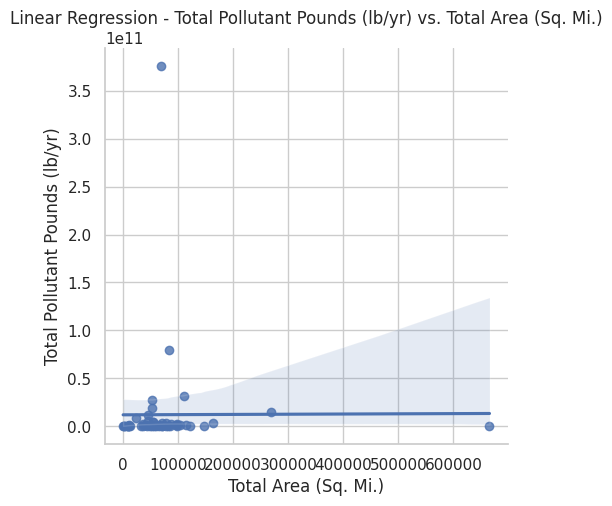

In [ ]:
# Linear Regression Visualization
sns.set(style = "whitegrid")

# Create a scatter plot with linear regression line
sns.lmplot(x = 'Total Area Sq. Mi.', y = 'Total Pollutant Pounds (lb/yr)', data = land_and_pollution)
plt.title('Linear Regression - Total Pollutant Pounds (lb/yr) vs. Total Area (Sq. Mi.)')
plt.xlabel('Total Area (Sq. Mi.)')
plt.ylabel('Total Pollutant Pounds (lb/yr)')
plt.show()

There are also more visualizations that are done in Tableau and linked on the White Paper

Code from previous scaffolds rearranged with the name of the current data set (some columns and dataframe names might not be the same as we cleaned, added, and overall changed a lot our data since then)

--------

In [ ]:
# finding the data type of each column
land_and_pollution.dtypes

EPA Region                                  int64
State                                      object
Total Area Sq. Mi.                        float64
Land Area Sq. Mi.                         float64
Water Area Total Sq. Mi.                  float64
Water Area Inland Sq. Mi.                 float64
Water Area Coastal Sq. Mi.                float64
Total # in ICIS-NPDES                     float64
Total # of Pollutant Loadings             float64
Total Pollutant Pounds (lb/yr)            float64
Total Toxic-Weighted Pounds (lb-eq/yr)    float64
dtype: object

In [ ]:
# counting NaN values in each column

nan_count = []

for col in land_and_pollution.columns:
  nan_count.append(land_and_pollution[col].isna().sum())

nan_count

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Counting NaN values
land_and_pollution.isnull().sum()

EPA Region                                0
State                                     0
Total Area Sq. Mi.                        0
Land Area Sq. Mi.                         0
Water Area Total Sq. Mi.                  0
Water Area Inland Sq. Mi.                 0
Water Area Coastal Sq. Mi.                0
Total # in ICIS-NPDES                     0
Total # of Pollutant Loadings             0
Total Pollutant Pounds (lb/yr)            0
Total Toxic-Weighted Pounds (lb-eq/yr)    0
dtype: int64

In [ ]:
# Determining frequencies for EPA region column
land_and_pollution['EPA Region'].value_counts()

EPA Region
4     8
8     6
1     6
3     6
5     6
6     5
10    4
9     4
7     4
2     2
Name: count, dtype: int64

In [ ]:
# We just realized that this totally should written with a for loop. Having
# realized this, it now pains us to look at this egregiously long code as much
# as it must pain you. We are short on time so we won't have a chance to fix it
# right now, but just know that we wish we could make this into a for loop and
# that in the future we will use for loops.

# Mean, Stdev, min, and max of '# of Majors in ICIS-NPDES' column
mean = joined_data['# of Majors in ICIS-NPDES'].mean()
std = joined_data['# of Majors in ICIS-NPDES'].std()
min = joined_data['# of Majors in ICIS-NPDES'].min()
max = joined_data['# of Majors in ICIS-NPDES'].max()
median = joined_data['# of Majors in ICIS-NPDES'].median()
print("'# of Majors in ICIS-NPDES' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(1), min, max, median)

# Mean, Stdev, min, and max of '# of Non-Majors in ICIS-NPDES' column
mean = joined_data['# of Non-Majors in ICIS-NPDES'].mean()
std = joined_data['# of Non-Majors in ICIS-NPDES'].std()
min = joined_data['# of Non-Majors in ICIS-NPDES'].min()
max = joined_data['# of Non-Majors in ICIS-NPDES'].max()
median = joined_data['# of Non-Majors in ICIS-NPDES'].median()
print("")
print("'# of Non-Majors in ICIS-NPDES' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(1), min, max, median)

# Mean, Stdev, min, and max of '# of Majors w/ Pollutant Loadings' column
mean = joined_data['# of Majors w/ Pollutant Loadings'].mean()
std = joined_data['# of Majors w/ Pollutant Loadings'].std()
min = joined_data['# of Majors w/ Pollutant Loadings'].min()
max = joined_data['# of Majors w/ Pollutant Loadings'].max()
median = joined_data['# of Majors w/ Pollutant Loadings'].median()
print("")
print("'# of Majors w/ Pollutant Loadings' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(1), min, max, median)

# Mean, Stdev, min, and max of '# of Non-Majors w/ Pollutant Loadings' column
mean = joined_data['# of Non-Majors w/ Pollutant Loadings'].mean()
std = joined_data['# of Non-Majors w/ Pollutant Loadings'].std()
min = joined_data['# of Non-Majors w/ Pollutant Loadings'].min()
max = joined_data['# of Non-Majors w/ Pollutant Loadings'].max()
median = joined_data['# of Non-Majors w/ Pollutant Loadings'].median()
print("")
print("'# of Non-Majors w/ Pollutant Loadings' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(1), min, max, median)

# Mean, Stdev, min, and max of '% of Majors w/ Pollutant Loadings' column
mean = joined_data['% of Majors w/ Pollutant Loadings'].mean()
std = joined_data['% of Majors w/ Pollutant Loadings'].std()
min = joined_data['% of Majors w/ Pollutant Loadings'].min()
max = joined_data['% of Majors w/ Pollutant Loadings'].max()
median = joined_data['% of Majors w/ Pollutant Loadings'].median()
print("")
print("'% of Majors w/ Pollutant Loadings' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(1), min, max, median)

# Mean, Stdev, min, and max of '% of Non-Majors w/ Pollutant Loadings' column
mean = joined_data['% of Non-Majors w/ Pollutant Loadings'].mean()
std = joined_data['% of Non-Majors w/ Pollutant Loadings'].std()
min = joined_data['% of Non-Majors w/ Pollutant Loadings'].min()
max = joined_data['% of Non-Majors w/ Pollutant Loadings'].max()
median = joined_data['% of Non-Majors w/ Pollutant Loadings'].median()
print("")
print("'% of Non-Majors w/ Pollutant Loadings' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(1), min, max, median)

# Mean, Stdev, min, and max of 'Total Pollutant Pounds (lb/yr) for Majors' column
mean = joined_data['Total Pollutant Pounds (lb/yr) for Majors'].mean()
std = joined_data['Total Pollutant Pounds (lb/yr) for Majors'].std()
min = joined_data['Total Pollutant Pounds (lb/yr) for Majors'].min()
max = joined_data['Total Pollutant Pounds (lb/yr) for Majors'].max()
median = joined_data['Total Pollutant Pounds (lb/yr) for Majors'].median()
print("")
print("'Total Pollutant Pounds (lb/yr) for Majors' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(1), min, max, median)

# Mean, Stdev, min, and max of 'Total Pollutant Pounds (lb/yr) for Non-Majors' column
mean = joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors'].mean()
std = joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors'].std()
min = joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors'].min()
max = joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors'].max()
median = joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors'].median()
print("")
print("'Total Pollutant Pounds (lb/yr) for Non-Majors' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(1), min, max, median)

# Mean, Stdev, min, and max of 'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors' column
mean = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'].mean()
std = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'].std()
min = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'].min()
max = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'].max()
median = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'].median()
print("")
print("'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

# Mean, Stdev, min, and max of 'Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors' column
mean = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors'].mean()
std = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors'].std()
min = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors'].min()
max = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors'].max()
median = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors'].median()
print("")
print("'Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

# Mean, Stdev, min, and max of 'Total Area Sq. Mi.' column
mean = joined_data['Total Area Sq. Mi.'].mean()
std = joined_data['Total Area Sq. Mi.'].std()
min = joined_data['Total Area Sq. Mi.'].min()
max = joined_data['Total Area Sq. Mi.'].max()
median = joined_data['Total Area Sq. Mi.'].median()
print("")
print("'Total Area Sq. Mi.' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

# Mean, Stdev, min, and max of 'Land Area Sq. Mi.' column
mean = joined_data['Land Area Sq. Mi.'].mean()
std = joined_data['Land Area Sq. Mi.'].std()
min = joined_data['Land Area Sq. Mi.'].min()
max = joined_data['Land Area Sq. Mi.'].max()
median = joined_data['Land Area Sq. Mi.'].median()
print("")
print("'Land Area Sq. Mi.' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

# Mean, Stdev, min, and max of 'Water Area Total Sq. Mi.' column
mean = joined_data['Water Area Total Sq. Mi.'].mean()
std = joined_data['Water Area Total Sq. Mi.'].std()
min = joined_data['Water Area Total Sq. Mi.'].min()
max = joined_data['Water Area Total Sq. Mi.'].max()
median = joined_data['Water Area Total Sq. Mi.'].median()
print("")
print("'Water Area Total Sq. Mi.' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

# Mean, Stdev, min, and max of 'Water Area Inland Sq. Mi.' column
mean = joined_data['Water Area Inland Sq. Mi.'].mean()
std = joined_data['Water Area Inland Sq. Mi.'].std()
min = joined_data['Water Area Inland Sq. Mi.'].min()
max = joined_data['Water Area Inland Sq. Mi.'].max()
median = joined_data['Water Area Inland Sq. Mi.'].median()
print("")
print("'Water Area Inland Sq. Mi.' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

# Mean, Stdev, min, and max of 'Water Area Coastal Sq. Mi.' column
mean = joined_data['Water Area Coastal Sq. Mi.'].mean()
std = joined_data['Water Area Coastal Sq. Mi.'].std()
min = joined_data['Water Area Coastal Sq. Mi.'].min()
max = joined_data['Water Area Coastal Sq. Mi.'].max()
median = joined_data['Water Area Coastal Sq. Mi.'].median()
print("")
print("'Water Area Coastal Sq. Mi.' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

# Mean, Stdev, min, and max of 'Total # in ICIS-NPDES' column
mean = joined_data['Total # in ICIS-NPDES'].mean()
std = joined_data['Total # in ICIS-NPDES'].std()
min = joined_data['Total # in ICIS-NPDES'].min()
max = joined_data['Total # in ICIS-NPDES'].max()
median = joined_data['Total # in ICIS-NPDES'].median()
print("")
print("'Total # in ICIS-NPDES' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

# Mean, Stdev, min, and max of 'Total # of Pollutant Loadings' column
mean = joined_data['Total # of Pollutant Loadings'].mean()
std = joined_data['Total # of Pollutant Loadings'].std()
min = joined_data['Total # of Pollutant Loadings'].min()
max = joined_data['Total # of Pollutant Loadings'].max()
median = joined_data['Total # of Pollutant Loadings'].median()
print("")
print("'Total # of Pollutant Loadings' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

# Mean, Stdev, min, and max of 'Total Pollutant Pounds (lb/yr)' column
mean = joined_data['Total Pollutant Pounds (lb/yr)'].mean()
std = joined_data['Total Pollutant Pounds (lb/yr)'].std()
min = joined_data['Total Pollutant Pounds (lb/yr)'].min()
max = joined_data['Total Pollutant Pounds (lb/yr)'].max()
median = joined_data['Total Pollutant Pounds (lb/yr)'].median()
print("")
print("'Total Pollutant Pounds (lb/yr)' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

# Mean, Stdev, min, and max of 'Total Toxic-Weighted Pounds (lb-eq/yr)' column
mean = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr)'].mean()
std = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr)'].std()
min = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr)'].min()
max = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr)'].max()
median = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr)'].median()
print("")
print("'Total Toxic-Weighted Pounds (lb-eq/yr)' Mean, Stdev, min, max, and median")
print(mean.round(1), std.round(), min, max, median)

'# of Majors in ICIS-NPDES' Mean, Stdev, min, max, and median
132.5 128.0 4.0 730.0 102.0

'# of Non-Majors in ICIS-NPDES' Mean, Stdev, min, max, and median
956.0 1590.3 7 8313 423.0

'# of Majors w/ Pollutant Loadings' Mean, Stdev, min, max, and median
124.0 118.6 4.0 693.0 99.0

'# of Non-Majors w/ Pollutant Loadings' Mean, Stdev, min, max, and median
614.9 744.7 5 3489 314.0

'% of Majors w/ Pollutant Loadings' Mean, Stdev, min, max, and median
94.9 10.2 42.0 100.0 98.0

'% of Non-Majors w/ Pollutant Loadings' Mean, Stdev, min, max, and median
77.6 19.9 18 100 86.0

'Total Pollutant Pounds (lb/yr) for Majors' Mean, Stdev, min, max, and median
1108335755.2 2275445455.2 514012.0 13545407258.0 211951259.0

'Total Pollutant Pounds (lb/yr) for Non-Majors' Mean, Stdev, min, max, and median
10969998174.1 53388569205.4 157813.0 374652367610.0 138126469.0

'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors' Mean, Stdev, min, max, and median
2163740.3 8360325.0 182.0 55936980.0 165587.0

'Tot

In [ ]:
# Getting list of all columns for plotting purposes: there are 21 columns index of [0, 20]
# where index= 0, 1 are our categorical columns for 'EPA Region' and 'State'
col_list = joined_data.columns.values.tolist()
col_list

['EPA Region',
 'State',
 '# of Majors in ICIS-NPDES',
 '# of Non-Majors in ICIS-NPDES',
 '# of Majors w/ Pollutant Loadings',
 '# of Non-Majors w/ Pollutant Loadings',
 '% of Majors w/ Pollutant Loadings',
 '% of Non-Majors w/ Pollutant Loadings',
 'Total Pollutant Pounds (lb/yr) for Majors',
 'Total Pollutant Pounds (lb/yr) for Non-Majors',
 'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors',
 'Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors',
 'Total Area Sq. Mi.',
 'Land Area Sq. Mi.',
 'Water Area Total Sq. Mi.',
 'Water Area Inland Sq. Mi.',
 'Water Area Coastal Sq. Mi.',
 'Total # in ICIS-NPDES',
 'Total # of Pollutant Loadings',
 'Total Pollutant Pounds (lb/yr)',
 'Total Toxic-Weighted Pounds (lb-eq/yr)']

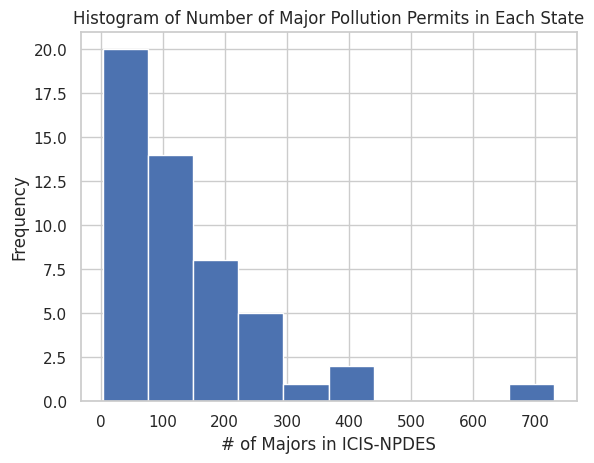

In [ ]:
# Column 3: Histogram of number of major polluting sites
plt.hist(joined_data['# of Majors in ICIS-NPDES'])
plt.xlabel('# of Majors in ICIS-NPDES')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Major Pollution Permits in Each State')
plt.show()

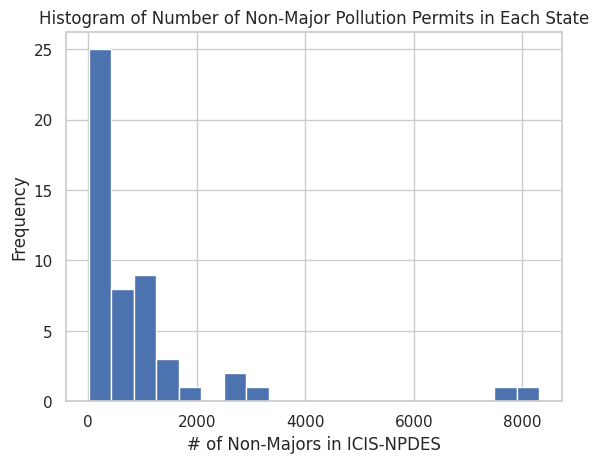

In [ ]:
# Column 4: Histogram of number of nonmajor polluting sites
plt.hist(joined_data['# of Non-Majors in ICIS-NPDES'], 20)
plt.xlabel('# of Non-Majors in ICIS-NPDES')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Non-Major Pollution Permits in Each State')
plt.show()

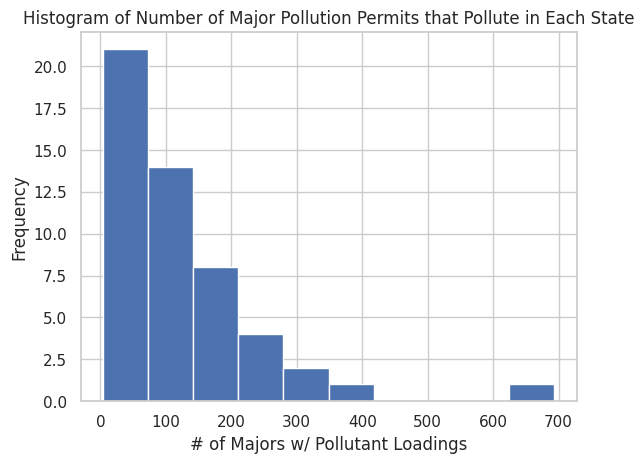

In [ ]:
# COLUMN 5: Histogram of number of major polluting sites with pollutant loadings
plt.hist(joined_data['# of Majors w/ Pollutant Loadings'])
plt.xlabel('# of Majors w/ Pollutant Loadings')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Major Pollution Permits that Pollute in Each State')
plt.show()

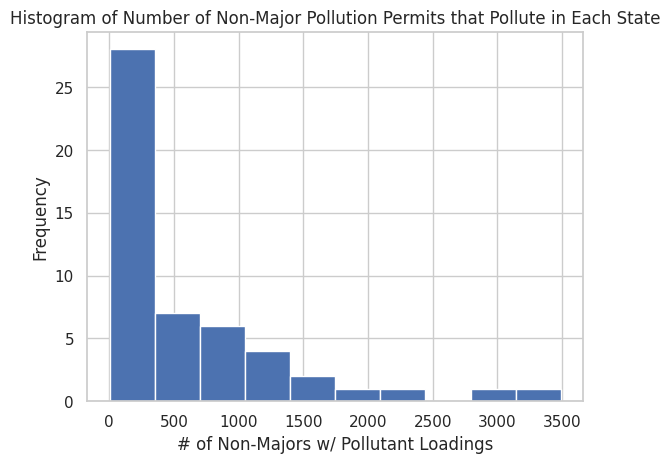

In [ ]:
# COLUMN 6: Histogram of number of nonmajor polluting sites with pollutant loadings
plt.hist(joined_data['# of Non-Majors w/ Pollutant Loadings'])
plt.xlabel('# of Non-Majors w/ Pollutant Loadings')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Non-Major Pollution Permits that Pollute in Each State')
plt.show()

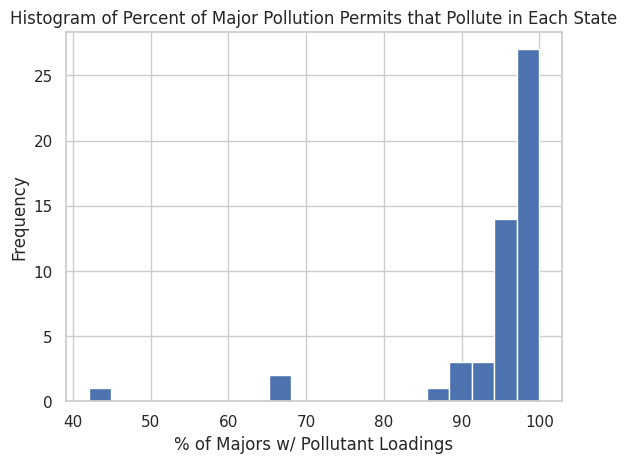

In [ ]:
# COLUMN 7:Histogram of percent of major polluting sites with pollutant loadings
plt.hist(joined_data['% of Majors w/ Pollutant Loadings'], 20)
plt.xlabel('% of Majors w/ Pollutant Loadings')
plt.ylabel('Frequency')
plt.title('Histogram of Percent of Major Pollution Permits that Pollute in Each State')
plt.show()

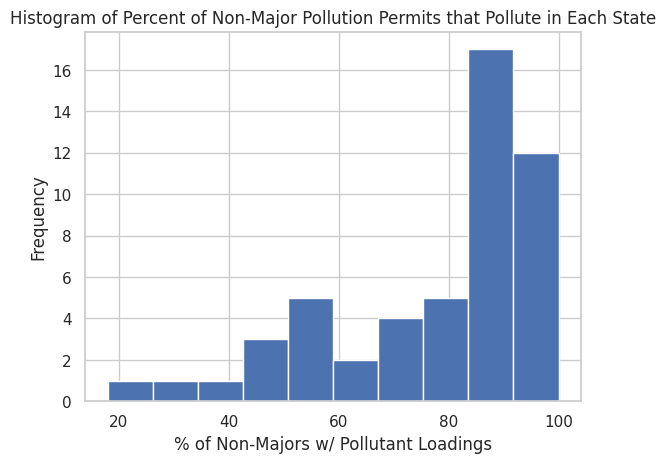

In [ ]:
# COLUMN 8: Histogram of percent of nonmajor polluting sites with pollutant loadings
plt.hist(joined_data['% of Non-Majors w/ Pollutant Loadings'])
plt.xlabel('% of Non-Majors w/ Pollutant Loadings')
plt.ylabel('Frequency')
plt.title('Histogram of Percent of Non-Major Pollution Permits that Pollute in Each State')
plt.show()

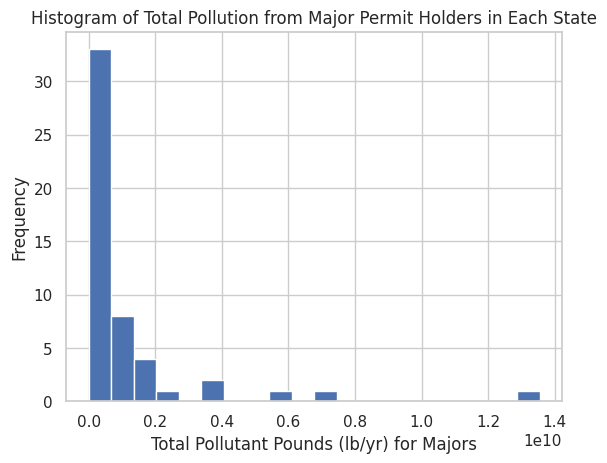

In [ ]:
# COLUMN 9: Histogram of total pollutant pounds produced per year at major pollution sites
plt.hist(joined_data['Total Pollutant Pounds (lb/yr) for Majors'], 20)
plt.xlabel('Total Pollutant Pounds (lb/yr) for Majors')
plt.ylabel('Frequency')
plt.title('Histogram of Total Pollution from Major Permit Holders in Each State')
plt.show()

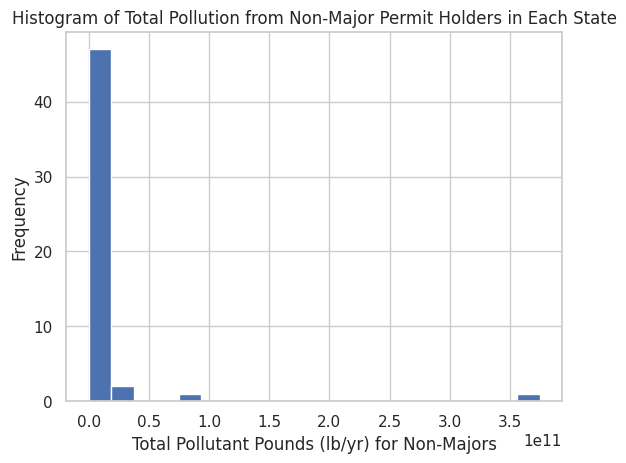

In [ ]:
# COLUMN 10: Histogram of total pollutant pounds produced per year at nonmajor pollution sites
plt.hist(joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors'], 20)
plt.xlabel('Total Pollutant Pounds (lb/yr) for Non-Majors')
plt.ylabel('Frequency')
plt.title('Histogram of Total Pollution from Non-Major Permit Holders in Each State')
plt.show()

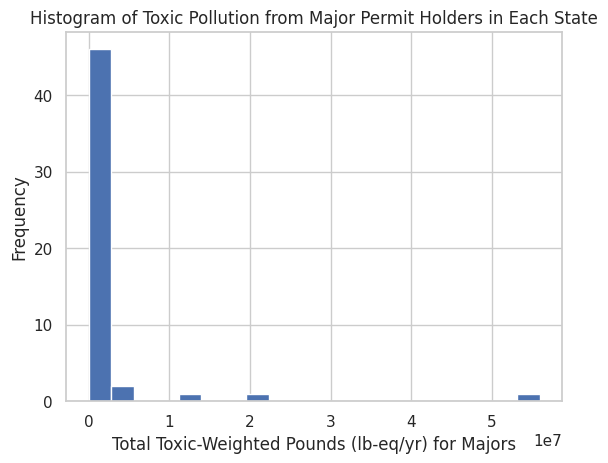

In [ ]:
# COLUMN 11: Histogram of total amount of toxic pollution produced at major pollution sites
plt.hist(joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'], 20)
plt.xlabel('Total Toxic-Weighted Pounds (lb-eq/yr) for Majors')
plt.ylabel('Frequency')
plt.title('Histogram of Toxic Pollution from Major Permit Holders in Each State')
plt.show()

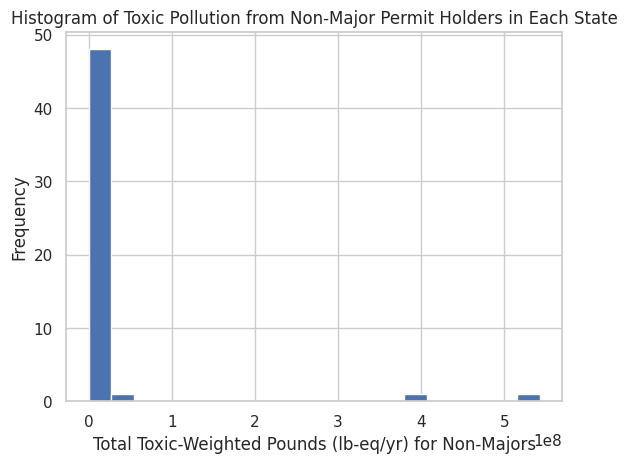

In [ ]:
# COLUMN 12: Histogram of total amount of toxic pollution produced at nonmajor pollution sites
plt.hist(joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors'], 20)
plt.xlabel('Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors')
plt.ylabel('Frequency')
plt.title('Histogram of Toxic Pollution from Non-Major Permit Holders in Each State')
plt.show()

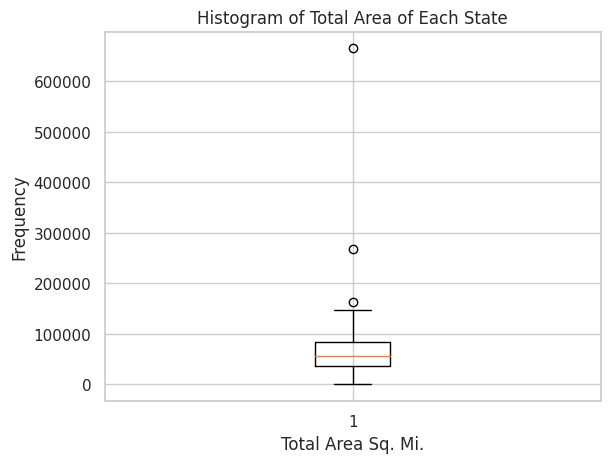

In [ ]:
# COLUMN 13: Creating a boxplot of the total area of each state
plt.figure()
plt.boxplot(joined_data['Total Area Sq. Mi.'])
plt.xlabel('Total Area Sq. Mi.')
plt.ylabel('Frequency')
plt.title('Histogram of Total Area of Each State')
plt.show()

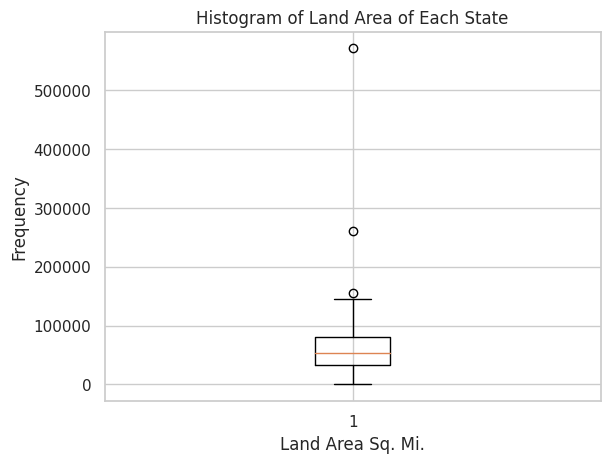

In [ ]:
# COLUMN 14: Boxplot of land area of each state
plt.figure()
plt.boxplot(joined_data['Land Area Sq. Mi.'])
plt.xlabel('Land Area Sq. Mi.')
plt.ylabel('Frequency')
plt.title('Histogram of Land Area of Each State')
plt.show()

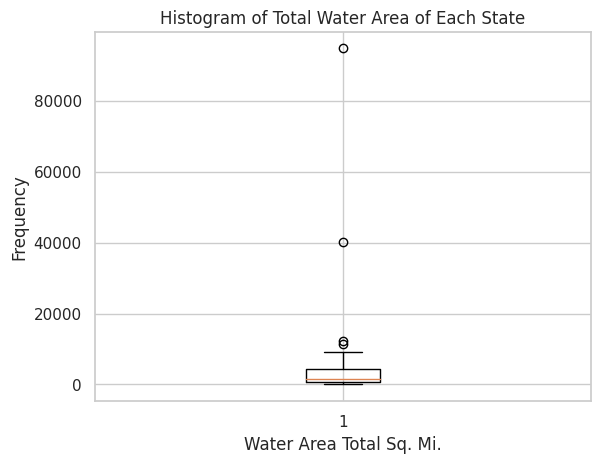

In [ ]:
# COLUMN 15: Boxplot of total water area of each state
plt.boxplot(joined_data['Water Area Total Sq. Mi.'])
plt.xlabel('Water Area Total Sq. Mi.')
plt.ylabel('Frequency')
plt.title('Histogram of Total Water Area of Each State')
plt.show()

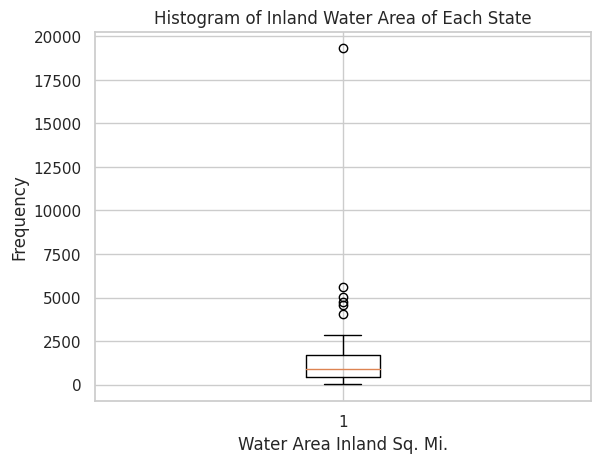

In [ ]:
# COLUMN 16: Boxplot of inland water area of each state
plt.boxplot(joined_data['Water Area Inland Sq. Mi.'])
plt.xlabel('Water Area Inland Sq. Mi.')
plt.ylabel('Frequency')
plt.title('Histogram of Inland Water Area of Each State')
plt.show()

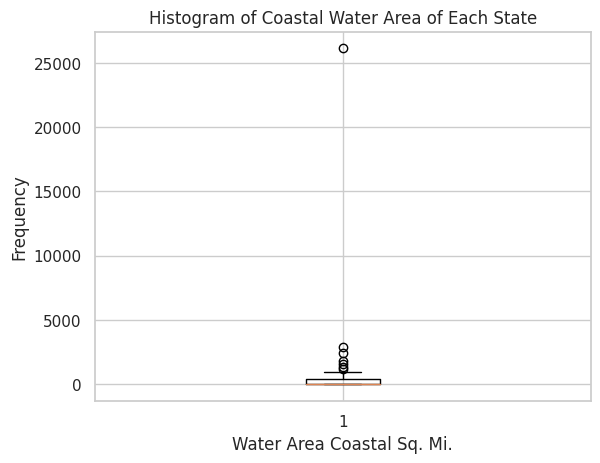

In [ ]:
# COLUMN 17: Boxplot of 'Water Area Coastal Sq. Mi.'
plt.boxplot(joined_data['Water Area Coastal Sq. Mi.'])
plt.xlabel('Water Area Coastal Sq. Mi.')
plt.ylabel('Frequency')
plt.title('Histogram of Coastal Water Area of Each State')
plt.show()

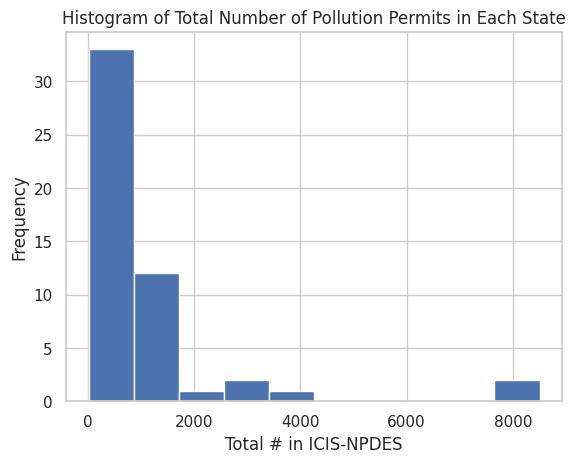

In [ ]:
# COLUMN 18: QQ plot of total ICIS-NPDES permits
plt.hist(joined_data['Total # in ICIS-NPDES'])
plt.xlabel('Total # in ICIS-NPDES')
plt.ylabel('Frequency')
plt.title('Histogram of Total Number of Pollution Permits in Each State')
plt.show()

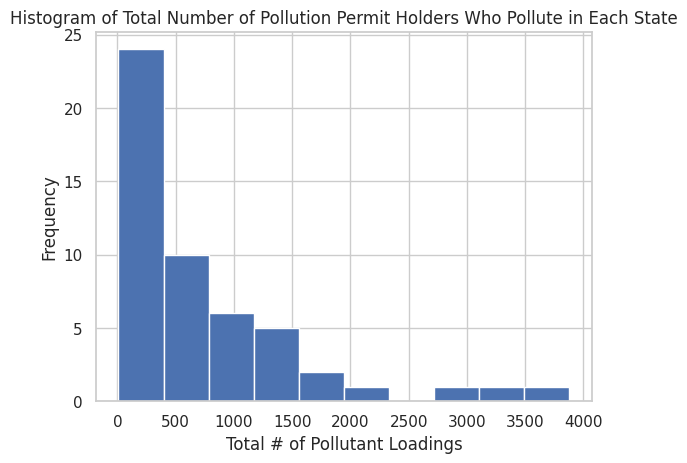

In [ ]:
# COLUMN 19: QQ plot of total number of Pollutant Loadings
plt.hist(joined_data['Total # of Pollutant Loadings'])
plt.xlabel('Total # of Pollutant Loadings')
plt.ylabel('Frequency')
plt.title('Histogram of Total Number of Pollution Permit Holders Who Pollute in Each State')
plt.show()

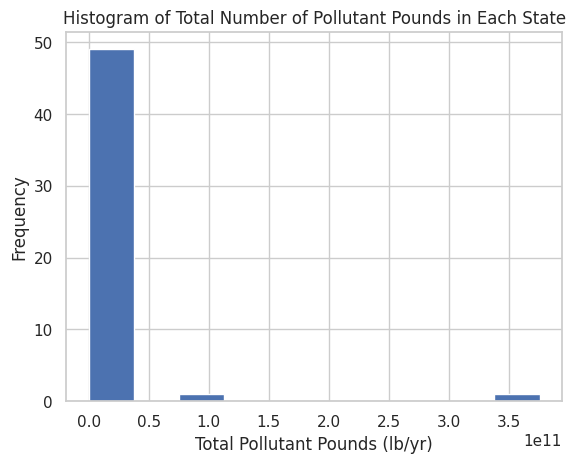

In [ ]:
# COLUMN 20: Histogram of total pollutant pounds per state annually
plt.hist(joined_data['Total Pollutant Pounds (lb/yr)'])
plt.xlabel('Total Pollutant Pounds (lb/yr)')
plt.ylabel('Frequency')
plt.title('Histogram of Total Number of Pollutant Pounds in Each State')
plt.show()

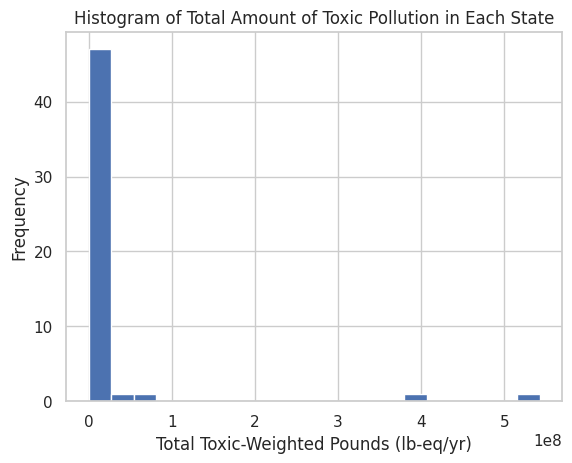

In [ ]:
# COLUMN 21: Histogram of total toxic weighted pounds
plt.figure()
plt.hist(joined_data['Total Toxic-Weighted Pounds (lb-eq/yr)'], 20)
plt.xlabel('Total Toxic-Weighted Pounds (lb-eq/yr)')
plt.ylabel('Frequency')
plt.title('Histogram of Total Amount of Toxic Pollution in Each State')
plt.show()

In [ ]:
# Can use .corr() to return a correlation between two continuous columns
# scatter plot
col_list

['EPA Region',
 'State',
 '# of Majors in ICIS-NPDES',
 '# of Non-Majors in ICIS-NPDES',
 '# of Majors w/ Pollutant Loadings',
 '# of Non-Majors w/ Pollutant Loadings',
 '% of Majors w/ Pollutant Loadings',
 '% of Non-Majors w/ Pollutant Loadings',
 'Total Pollutant Pounds (lb/yr) for Majors',
 'Total Pollutant Pounds (lb/yr) for Non-Majors',
 'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors',
 'Total Toxic-Weighted Pounds (lb-eq/yr) for Non-Majors',
 'Total Area Sq. Mi.',
 'Land Area Sq. Mi.',
 'Water Area Total Sq. Mi.',
 'Water Area Inland Sq. Mi.',
 'Water Area Coastal Sq. Mi.',
 'Total # in ICIS-NPDES',
 'Total # of Pollutant Loadings',
 'Total Pollutant Pounds (lb/yr)',
 'Total Toxic-Weighted Pounds (lb-eq/yr)']

In [ ]:
# '# of Majors in ICIS-NPDES' and 'Total Pollutant Pounds (lb/yr) for Majors'
# correlation:
x = joined_data['# of Majors in ICIS-NPDES']
y = joined_data['Total Pollutant Pounds (lb/yr) for Majors']
x.corr(y)

0.824945522590059

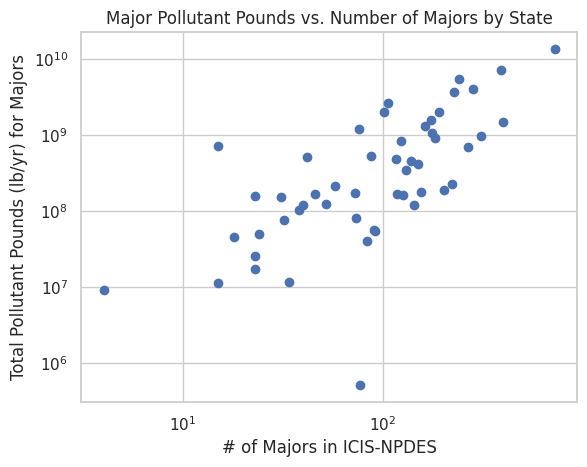

In [ ]:
# '# of Majors in ICIS-NPDES' and 'Total Pollutant Pounds (lb/yr) for Majors'
# Scatter plot:
x = joined_data['# of Majors in ICIS-NPDES']
y = joined_data['Total Pollutant Pounds (lb/yr) for Majors']
plt.scatter(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('# of Majors in ICIS-NPDES')
plt.ylabel('Total Pollutant Pounds (lb/yr) for Majors')
plt.title('Major Pollutant Pounds vs. Number of Majors by State')
plt.show()

In [ ]:
# '# of Majors in ICIS-NPDES' and 'Total Pollutant Pounds (lb/yr) for Non-Majors'
# correlation:
x = joined_data['# of Majors in ICIS-NPDES']
y = joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors']
x.corr(y)

0.031612193071707276

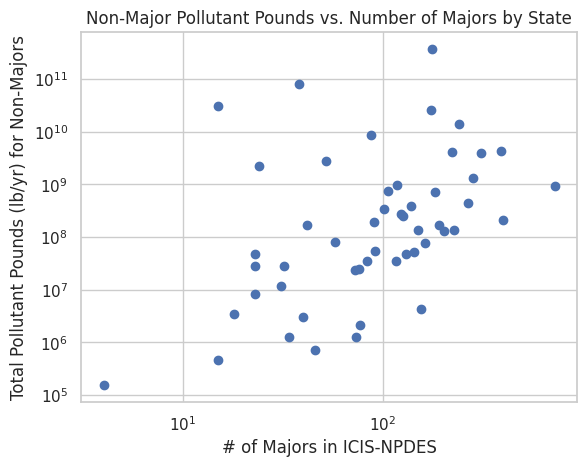

In [ ]:
# '# of Majors in ICIS-NPDES' and 'Total Pollutant Pounds (lb/yr) for Non-Majors'
# Scatter plot:
x = joined_data['# of Majors in ICIS-NPDES']
y = joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors']
plt.scatter(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('# of Majors in ICIS-NPDES')
plt.ylabel('Total Pollutant Pounds (lb/yr) for Non-Majors')
plt.title('Non-Major Pollutant Pounds vs. Number of Majors by State')
plt.show()

In [ ]:
# '# of Non-Majors in ICIS-NPDES' and 'Total Pollutant Pounds (lb/yr) for Non-Majors'
# correlation:
x = joined_data['# of Non-Majors in ICIS-NPDES']
y = joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors']
x.corr(y)

0.13846812132360942

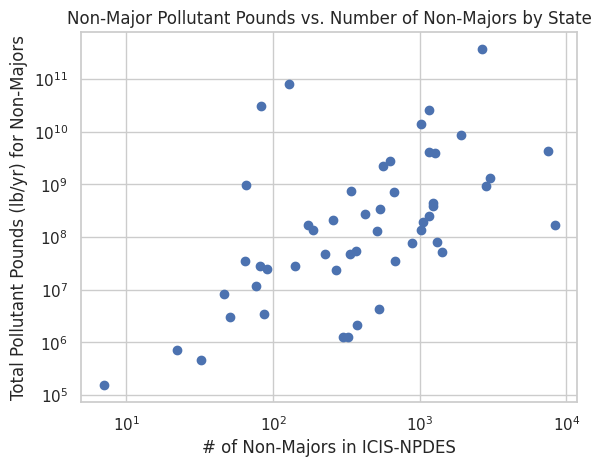

In [ ]:
# '# of Non-Majors in ICIS-NPDES' and 'Total Pollutant Pounds (lb/yr) for Non-Majors'
# Scatter plot:
x = joined_data['# of Non-Majors in ICIS-NPDES']
y = joined_data['Total Pollutant Pounds (lb/yr) for Non-Majors']
plt.scatter(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('# of Non-Majors in ICIS-NPDES')
plt.ylabel('Total Pollutant Pounds (lb/yr) for Non-Majors')
plt.title('Non-Major Pollutant Pounds vs. Number of Non-Majors by State')
plt.show()

In [ ]:
# '# of Majors in ICIS-NPDES' and 'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'
# correlation:
x = joined_data['# of Majors in ICIS-NPDES']
y = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Majors']
x.corr(y)

0.04476375611909986

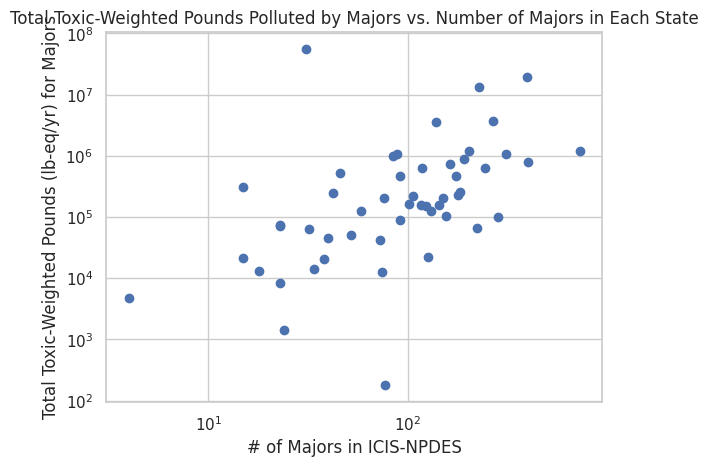

In [ ]:
# '# of Majors in ICIS-NPDES' and 'Total Toxic-Weighted Pounds (lb-eq/yr) for Majors'
# scatter plot:
x = joined_data['# of Majors in ICIS-NPDES']
y = joined_data['Total Toxic-Weighted Pounds (lb-eq/yr) for Majors']
plt.scatter(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('# of Majors in ICIS-NPDES')
plt.ylabel('Total Toxic-Weighted Pounds (lb-eq/yr) for Majors')
plt.title('Total Toxic-Weighted Pounds Polluted by Majors vs. Number of Majors in Each State')
plt.show()

In [ ]:
# '# of Majors in ICIS-NPDES' and '# of Non-Majors in ICIS-NPDES'
# correlation
x = joined_data['# of Majors in ICIS-NPDES']
y = joined_data['# of Non-Majors in ICIS-NPDES']
x.corr(y)

0.49177321642268995

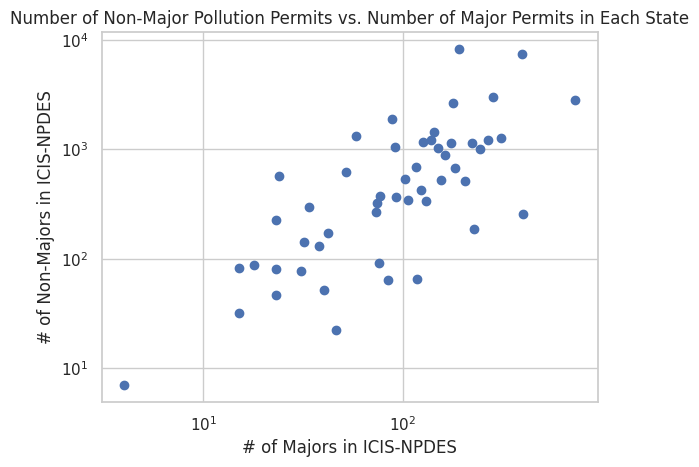

In [ ]:
# '# of Majors in ICIS-NPDES' and '# of Non-Majors in ICIS-NPDES'
# scatter plot:
x = joined_data['# of Majors in ICIS-NPDES']
y = joined_data['# of Non-Majors in ICIS-NPDES']
plt.scatter(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('# of Majors in ICIS-NPDES')
plt.ylabel('# of Non-Majors in ICIS-NPDES')
plt.title('Number of Non-Major Pollution Permits vs. Number of Major Permits in Each State')
plt.show()

In [ ]:
# 'Total Area Sq. Mi.' and 'Total # in ICIS-NPDES'
# corr:
x = joined_data['Total Area Sq. Mi.']
y = joined_data['Total # in ICIS-NPDES']
x.corr(y)

-0.049693029034755844

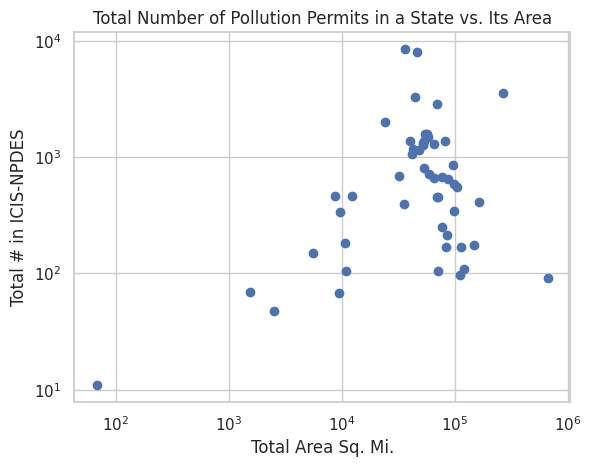

In [ ]:
# 'Total Area Sq. Mi.' and 'Total # in ICIS-NPDES'
# scatter plot:
x = joined_data['Total Area Sq. Mi.']
y = joined_data['Total # in ICIS-NPDES']
plt.scatter(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Total Area Sq. Mi.')
plt.ylabel('Total # in ICIS-NPDES')
plt.title('Total Number of Pollution Permits in a State vs. Its Area')
plt.show()

In [ ]:
# 'Total Area Sq. Mi.' and 'Total Pollutant Pounds (lb/yr)'
# corr:
x = joined_data['Total Area Sq. Mi.']
y = joined_data['Total Pollutant Pounds (lb/yr)']
x.corr(y)

0.003810492233111632

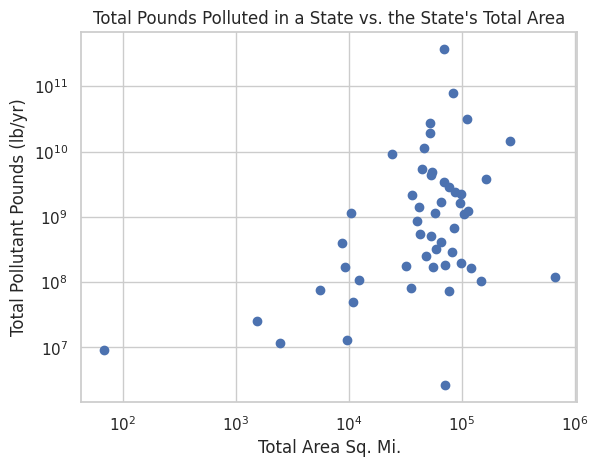

In [ ]:
# 'Total Area Sq. Mi.' and 'Total Pollutant Pounds (lb/yr)'
# scatter plot:
x = joined_data['Total Area Sq. Mi.']
y = joined_data['Total Pollutant Pounds (lb/yr)']
plt.scatter(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Total Area Sq. Mi.')
plt.ylabel('Total Pollutant Pounds (lb/yr)')
plt.title("Total Pounds Polluted in a State vs. the State's Total Area")
plt.show()

In [ ]:
# 'Water Area Coastal Sq. Mi.' and 'Total Pollutant Pounds (lb/yr)'
# corr:
x = joined_data['Water Area Coastal Sq. Mi.']
y = joined_data['Total Pollutant Pounds (lb/yr)']
x.corr(y)

-0.04292853471923705

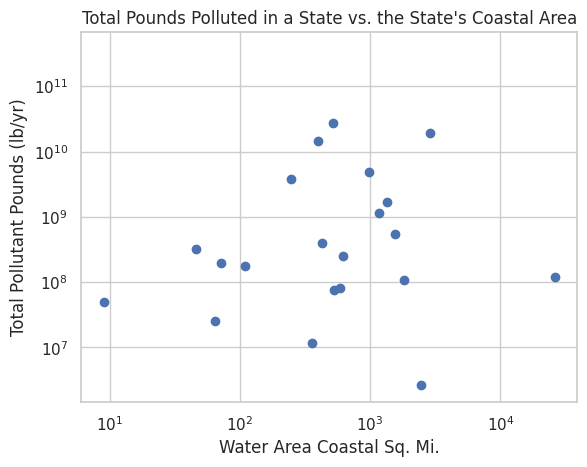

In [ ]:
# 'Water Area Coastal Sq. Mi.' and 'Total Pollutant Pounds (lb/yr)'
# scatter plot:
x = joined_data['Water Area Coastal Sq. Mi.']
y = joined_data['Total Pollutant Pounds (lb/yr)']
plt.scatter(x, y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Water Area Coastal Sq. Mi.')
plt.ylabel('Total Pollutant Pounds (lb/yr)')
plt.title("Total Pounds Polluted in a State vs. the State's Coastal Area")
plt.show()

Creating a Linear Model (OLS Linear Model)

In [ ]:
# Defining variables for the linear model
y = land_and_pollution['Total Pollutant Pounds (lb/yr)']
X = land_and_pollution[['Total Area Sq. Mi.', 'Land Area Sq. Mi.',
                        'Water Area Total Sq. Mi.', 'Water Area Inland Sq. Mi.',
                        'Water Area Coastal Sq. Mi.']]

In [ ]:
# Adding a constant
X = sm.add_constant(X)

In [ ]:
# Defining the model
model = sm.OLS(y, X, missing='drop')

In [ ]:
# Fitting the model
results = model.fit()

In [ ]:
# Summarizing the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Total Pollutant Pounds (lb/yr)   R-squared:                       0.013
Model:                                        OLS   Adj. R-squared:                 -0.096
Method:                             Least Squares   F-statistic:                    0.1229
Date:                            Mon, 06 May 2024   Prob (F-statistic):              0.987
Time:                                    04:39:01   Log-Likelihood:                -1331.3
No. Observations:                              51   AIC:                             2675.
Df Residuals:                                  45   BIC:                             2686.
Df Model:                                       5                                         
Covariance Type:                        nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       8.799e+09   1.21e+10      0.729      0.470   -1.55e+10    3.31e+10
Total Area Sq. Mi.          3.541e+09   1.67e+10      0.212      0.833   -3.01e+10    3.72e+10
Land Area Sq. Mi.          -3.541e+09   1.67e+10     -0.212      0.833   -3.72e+10    3.01e+10
Water Area Total Sq. Mi.   -3.542e+09   1.67e+10     -0.212      0.833   -3.72e+10    3.01e+10
Water Area Inland Sq. Mi.  -1.077e+06   7.79e+06     -0.138      0.891   -1.68e+07    1.46e+07
Water Area Coastal Sq. Mi.  -6.09e+05   5.87e+06     -0.104      0.918   -1.24e+07    1.12e+07
==============================================================================
Omnibus:                      107.858   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3809.001
Skew:                           6.342   Prob(JB):                         0.00
Kurtosis:                      43.393   Cond. No.                     6.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now that we have a model, we need to test the LINE assumptions (question 3): Linearity, Independence, Normality, and Equal Variance

Testing Normality

(array([47.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-2.34568670e+10,  1.49228268e+10,  5.33025207e+10,  9.16822146e+10,
         1.30061908e+11,  1.68441602e+11,  2.06821296e+11,  2.45200990e+11,
         2.83580684e+11,  3.21960378e+11,  3.60340072e+11]),
 <BarContainer object of 10 artists>)

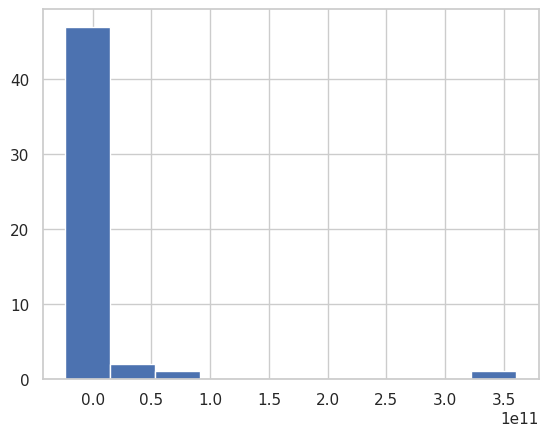

In [ ]:
# Testing normality
# Plotting histogram of residuals
plt.hist(results.resid)

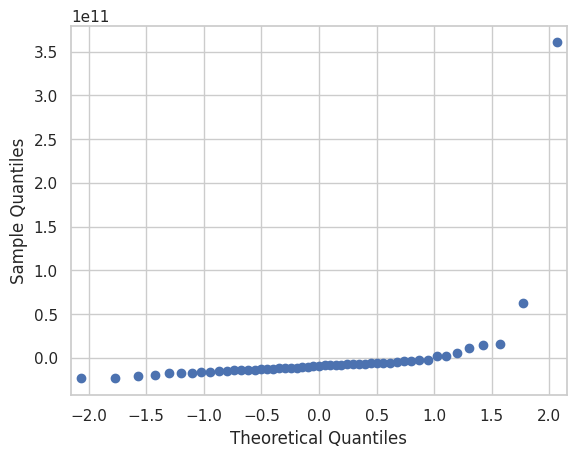

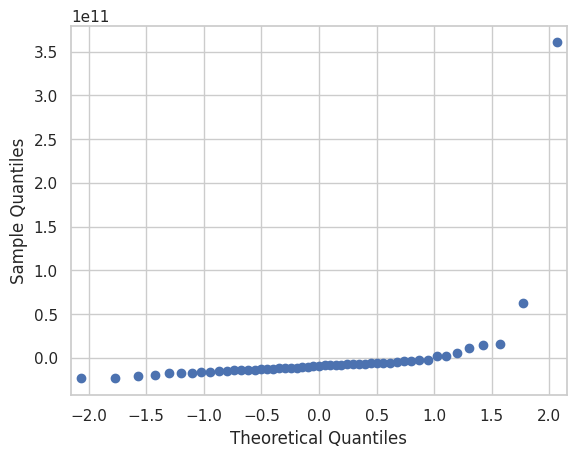

In [ ]:
sm.qqplot(results.resid)

In [ ]:
# The anderson-darling test for normality
sms.normal_ad(results.resid)

(12.554454623331942, 1.832137838232131e-30)

The assumption for normality is NOT met because the p-value (the second output) is less than 0.05.

In [ ]:
# Testing Independence:
# Using Durbin Watson Test
# Import statsmodels.stats.api library as smapi
import statsmodels.stats.api as smapi

In [ ]:
# Call smapi.durbin_watson
# The magnitude of the Durbin Watson is from 0 to 4, with a value of 2 being non-correlated.
sms.durbin_watson(results.resid)

2.1443444480070992

The assumption of independence is met as the magnitude of the Durbin Watson test is in close proximity to the value 2.

In [ ]:
# Testing for equal variance using the Breuschpagan test
# The null hypothesis for the Breuschpagan test is that the residuals are distributed with equal variance.

# This test returns 4 objects:

# Lagrange multiplier statistic
# The Lagrange multiplier p-value
# The f-value
# The f p-value

lms, p_val, f_val, f_p_val = sms.het_breuschpagan(results.resid, results.model.exog)
print(lms, p_val, f_val, f_p_val)

0.3888140461629852 0.9956321015171397 0.06914136370285115 0.996462129541655


In this instance, we believe that linarity is met given the fact that the p value is greater than .05. Since the F-score is less than one, the variance between the samples is no greater than the variance within the samples and the samples probably come from populations with the same mean. With regard to equal variance, we do not think that equal variance is met and reject the null hypothesis that it is, given the F value is less than 1 and the F-p value is greater than .05, demonstrating that the results are statistically significant.

In [ ]:
# Had to use SVD over PCA due to complexity of dataframe with columns datatypes

# Preparing data for PCA
X = land_and_pollution[['Total Area Sq. Mi.', 'Land Area Sq. Mi.',
                        'Water Area Total Sq. Mi.', 'Water Area Inland Sq. Mi.',
                        'Water Area Coastal Sq. Mi.']]
Y = land_and_pollution['Total Pollutant Pounds (lb/yr)']

# Preprocessing: Handle categorical variables and missing values
categorical_columns = ['State']

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy = 'mean'), X.select_dtypes(include = ['number']).columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Apply preprocessing
#X_processed = preprocessor.fit_transform(X)

# Initialize TruncatedSVD
svd = TruncatedSVD()

# Fit TruncatedSVD model to the processed data
svd.fit(X)

# Transform data to principal components
svd_components = svd.transform(X)

# Initialize OLS model with the principal components
X_with_svd = sm.add_constant(svd_components)

# Initialize OLS model
model = sm.OLS(Y, X_with_svd)

# Fit OLS model to the data
ols_land_and_pollution = model.fit()

# Show land_and_pollution results
print(ols_land_and_pollution.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Total Pollutant Pounds (lb/yr)   R-squared:                       0.012
Model:                                        OLS   Adj. R-squared:                 -0.029
Method:                             Least Squares   F-statistic:                    0.2848
Date:                            Mon, 06 May 2024   Prob (F-statistic):              0.753
Time:                                    04:39:02   Log-Likelihood:                -1331.3
No. Observations:                              51   AIC:                             2669.
Df Residuals:                                  48   BIC:                             2674.
Df Model:                                       2                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

Robust Linear Model

Creating a robust model to address the failed normality assumption

In [ ]:
# Defining variables for the linear model
y = land_and_pollution['Total Pollutant Pounds (lb/yr)']
X = land_and_pollution[['Total Area Sq. Mi.', 'Land Area Sq. Mi.',
                        'Water Area Total Sq. Mi.', 'Water Area Inland Sq. Mi.',
                        'Water Area Coastal Sq. Mi.']]

In [ ]:
# Adding a constant
X = sm.add_constant(X)

In [ ]:
# Defining the robust model
robust_model = sm.RLM(y, X, missing='drop')

In [ ]:
# Fitting the robust model and producing a summary of the results
robust_results = robust_model.fit()
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Robust linear Model Regression Results                          
==========================================================================================
Dep. Variable:     Total Pollutant Pounds (lb/yr)   No. Observations:                   51
Model:                                        RLM   Df Residuals:                       45
Method:                                      IRLS   Df Model:                            5
Norm:                                      HuberT                                         
Scale Est.:                                   mad                                         
Cov Type:                                      H1                                         
Date:                            Mon, 06 May 2024                                         
Time:                                    04:39:02                                         
No. Iterations:                                 2                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       2.512e+09   1.13e+09      2.223      0.026    2.97e+08    4.73e+09
Total Area Sq. Mi.          1.846e+08   1.56e+09      0.118      0.906   -2.88e+09    3.25e+09
Land Area Sq. Mi.          -1.845e+08   1.56e+09     -0.118      0.906   -3.25e+09    2.88e+09
Water Area Total Sq. Mi.   -1.847e+08   1.56e+09     -0.118      0.906   -3.25e+09    2.88e+09
Water Area Inland Sq. Mi.    5.71e+05   7.29e+05      0.783      0.434   -8.58e+05       2e+06
Water Area Coastal Sq. Mi. -5.498e+05    5.5e+05     -1.000      0.317   -1.63e+06    5.28e+05
==============================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""